# FINAL NPZD PROTOTYPE

In [1]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [2]:
from phydra.components.variables import SV, SVArray

In [3]:

from phydra.components.fluxes import (LinearForcingInput, LinearMortalityExchange,
                                      QuadraticMortality,
                                      ExponentialGrowth, MonodGrowth,
                                      HollingTypeIII, MultiFlux_Test)
from phydra.components.forcings import ConstantForcing

In [4]:
import numpy as np

In [5]:
NPZD = phydra.create({'Nutrient':SV,
                      'Phytoplankton':SVArray,

                      'Input':LinearForcingInput, 
                      'Monod': MonodGrowth,
                      
                      # HERE NEED TO ADD THIS:
                      'N0':ConstantForcing
                     })

In [6]:
NPZD

<xsimlab.Model (8 processes, 14 inputs)>
Core
    solver_type       [in]
Time
    time              [in] ('input_time',) sequence of time points ...
Nutrient
    var_init          [in] initial value / basic state variable
    var_label         [in] label / basic state variable
Phytoplankton
    var_init          [in] ('var',) initial value / basic state var...
    var_label         [in] label / basic state variable
N0
    forcing_label     [in] label / 
    value             [in] constant value of forcing
Input
    rate              [in] linear rate of change
    var               [in] label reference / variable affected by flux
    forcing           [in] label reference / forcing affecting flux
Monod
    consumer          [in] label reference / 
    halfsat           [in] ('var',) 
    resource          [in] label reference / 
Solver

In [19]:
odeint_setup = phydra.setup('odeint', NPZD,
            time=np.arange(0,100,0.1),
            input_vars={
                'Nutrient':{'var_label':'N', 'var_init':3.},
                'Phytoplankton':{'var_label':'P', 'var_init':[0.1, 0.1, 0.1]},
                
                'Input':{'var':'N', 'rate':0.1, 'forcing':'N0'},
                
                'Monod':{'consumer':'P', 'resource':'N', 'halfsat':[1.5, 1.51,1.52]},
                
                'N0':{'forcing_label':'N0', 'value':2.}
            },
            output_vars={'Nutrient__var_value',
                         'Phytoplankton__var_value',
                         'Input__input_value',
                         
                         'N0__forcing_value'
                        }
            )

In [32]:
with NPZD:
    odeint_out = odeint_setup.xsimlab.run()

initializing model backend
Initializing Model Time
adding variable here:
FULL DIMS (1000,)
flux Time_time_flux (1000,)
Initializing component Nutrient
adding variable here:
FULL DIMS (1000,)
Initializing component Phytoplankton
adding variable here:
FULL DIMS (3, 1000)
Initializing component N0
forcing function is in directory: /Users/bpo/Documents/GitHub/phydra/prototypes
forcing_val: 2.0
Initializing component Input
flux Input_input (1000,)
Initializing component Monod
flux Monod_uptake (3, 1000)
assembling model
SOLVER : <phydra.backend.solvers.ODEINTSolver object at 0x163166100>
lets do the magic at model assembly
variables time (1000,)
variables N (1000,)
variables P (3, 1000)
values Time_time_flux (1000,)
values Input_input (1000,)
values Monod_uptake (3, 1000)
Model is assembled:
Model contains: 
Variables:['time', 'N', 'P'] 
Parameters:['N0_value', 'Input_rate', 'Monod_halfsat'] 
Forcings:['N0'] 
Fluxes:['Time_time_flux', 'Input_input', 'Monod_uptake'] 
Full Model Dimensions:[(

In [33]:
odeint_out

<xarray.Dataset>
Dimensions:                   (clock: 2, input_time: 1000, time: 1000, var: 3)
Coordinates:
  * clock                     (clock) float64 0.0 0.1
Dimensions without coordinates: input_time, time, var
Data variables:
    Core__solver_type         <U6 'odeint'
    Input__forcing            <U2 'N0'
    Input__input_value        (time) float64 0.2 0.2 0.2 0.2 ... 0.2 0.2 0.2 0.2
    Input__rate               float64 0.1
    Input__var                <U1 'N'
    Monod__consumer           <U1 'P'
    Monod__halfsat            (var) float64 1.5 1.51 1.52
    Monod__resource           <U1 'N'
    N0__forcing_label         <U2 'N0'
    N0__forcing_value         (time) float64 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0
    N0__value                 float64 2.0
    Nutrient__var_init        float64 3.0
    Nutrient__var_label       <U1 'N'
    Nutrient__var_value       (time) float64 3.0 2.999 2.997 ... 0.01311 0.0131
    Phytoplankton__var_init   (var) float64 0.1 0.1 0.1
    Phytoplankton__var_label  <U1 'P'
    Phytoplankton__var_value  (var, time) float64 0.1 0.1069 ... 7.606 7.612
    Time__time                (input_time) float64 0.0 0.1 0.2 ... 99.8 99.9

In [34]:
import matplotlib.pyplot as plt

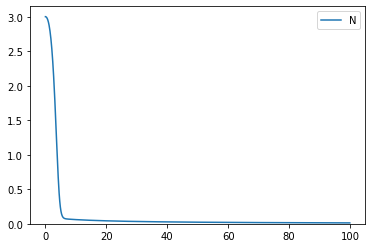

In [35]:
time = odeint_out.Time__time

plt.plot(time, odeint_out.Nutrient__var_value, label='N')
plt.ylim(bottom=0)
plt.legend()

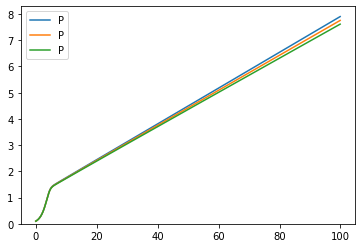

In [36]:
plt.plot(time, odeint_out.Phytoplankton__var_value.T, label='P')
plt.ylim(bottom=0)
plt.legend()

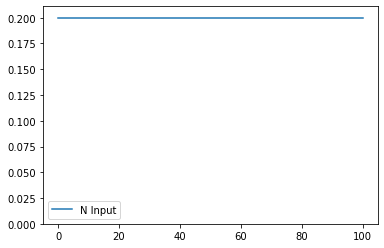

In [37]:
plt.plot(time, odeint_out.Input__input_value, label='N Input')
plt.ylim(bottom=0)
plt.legend()

In [38]:
stepwise_setup = phydra.update_setup(model=NPZD, old_setup=odeint_setup, new_solver="stepwise")

In [39]:
with NPZD:
    stepwise_out = stepwise_setup.xsimlab.run()

initializing model backend
Initializing Model Time
time 0
adding variable here:
Initializing component Nutrient
N 3.0
adding variable here:
Initializing component Phytoplankton
P [0.1 0.1 0.1]
adding variable here:
Initializing component N0
forcing function is in directory: /Users/bpo/Documents/GitHub/phydra/prototypes
forcing_val: 2.0
Initializing component Input
Initializing component Monod
assembling model
SOLVER : <phydra.backend.solvers.StepwiseSolver object at 0x1633fa4c0>
lets do the magic at model assembly
Model is assembled:
Model contains: 
Variables:['time', 'N', 'P'] 
Parameters:['N0_value', 'Input_rate', 'Monod_halfsat'] 
Forcings:['N0'] 
Fluxes:['Time_time_flux', 'Input_input', 'Monod_uptake'] 
Full Model Dimensions:[('time', None), ('N', None), ('P', 3), ('Time_time_flux', None), ('Input_input', None), ('Monod_uptake', 3)] 

finalizing: cleanup
Model was solved in 0.65679 seconds


In [40]:
import matplotlib.pyplot as plt

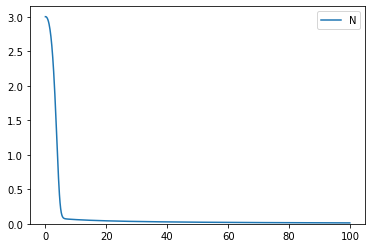

In [41]:
time = stepwise_out.Time__time

plt.plot(time, stepwise_out.Nutrient__var_value, label='N')
plt.ylim(bottom=0)
plt.legend()

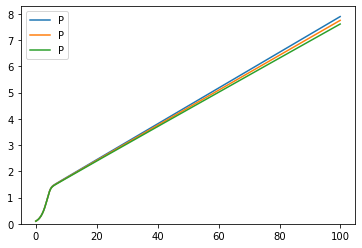

In [42]:
plt.plot(time, stepwise_out.Phytoplankton__var_value.T, label='P')
plt.ylim(bottom=0)
plt.legend()

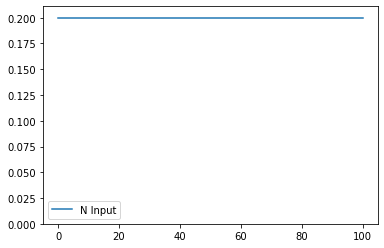

In [43]:
plt.plot(time, stepwise_out.Input__input_value, label='N Input')
plt.ylim(bottom=0)
plt.legend()

In [17]:
gekko_setup = phydra.update_setup(model=NPZD, 
                                  old_setup=odeint_setup, 
                                  new_solver="gekko", 
                                  # gekko solver works better (much faster) with smaller time steps:
                                  # new_time=np.arange(0,201,.1)
                                 )

In [18]:
with NPZD:
    gekko_out = gekko_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component N0
forcing function is in directory: /Users/bpo/Documents/GitHub/phydra/prototypes
forcing_val: 2.0
Initializing component Input
var <class 'gekko.gk_variable.GK_SV'> n    forcing <class 'gekko.gk_parameter.GKParameter'> n0    rate <class 'gekko.gk_parameter.GKParameter'> input_rate
Initializing component Monod
assembling model
SOLVER : <phydra.backend.solvers.GEKKOSolver object at 0x157c81a60>
lets do the magic at model assembly
CURRENT STATE
dict_values([])
FLAT STATE: dict_values([])
defaultdict(None, {})


KeyError: 'N'

In [20]:
time = gekko_out.Time__time
plt.plot(time, gekko_out.Nutrient__var_value, label='N')
plt.ylim(bottom=0)
plt.legend()

NameError: name 'gekko_out' is not defined

In [21]:
plt.plot(time, gekko_out.Input__input_value, label='N_input')
plt.ylim(bottom=0)
plt.legend()

NameError: name 'time' is not defined